In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


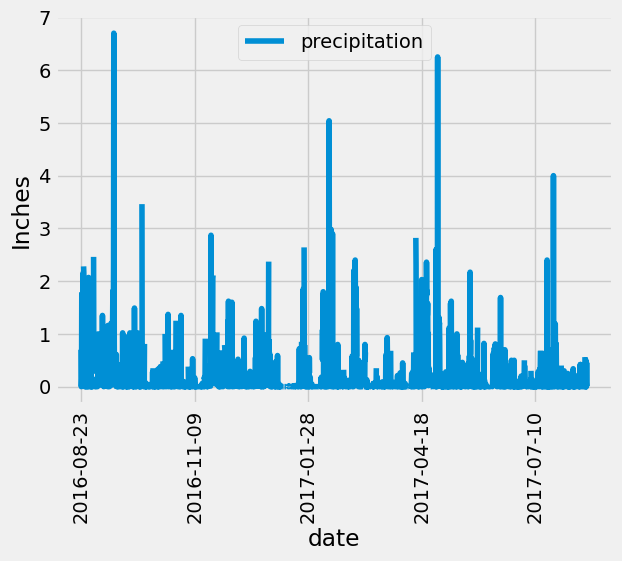

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
one_year_ago = last_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date,Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date.desc())\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
columns = ['date', 'precipitation']
df = pd.DataFrame(precipitation_data, columns=columns)

# Sort the dataframe by date
df = df.sort_values('date').set_index("date")


# Use Pandas Plotting with Matplotlib to plot the data

df.plot(ylabel="Inches")
plt.legend(loc='upper center')

plt.xticks(rotation=90)

plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()

print("Precipitation")
summary_stats

Precipitation


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.name)).scalar()

print(total_stations)

9


In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())

# Display the result

print("Most Active Station:", most_active_stations.first().station)
most_active_stations.all()

Most Active Station: USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_values = session.query(
    func.min(Measurement.tobs).label('min_temperature'),
    func.max(Measurement.tobs).label('max_temperature'),
    func.avg(Measurement.tobs).label('avg_temperature')
).filter(Measurement.station == most_active_stations.first()[0]).first()

print(f"[{temperature_values.min_temperature}, {temperature_values.max_temperature}, {temperature_values.avg_temperature}]")


[54.0, 85.0, 71.66378066378067]


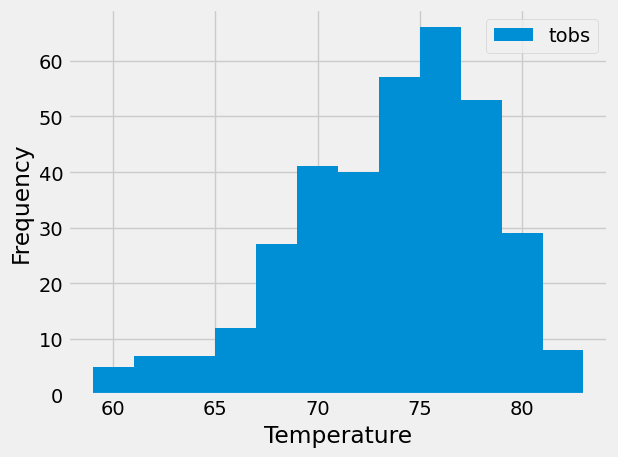

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_stations.first()[0], Measurement.date >= one_year_ago)\
    .all()

columns = ['tobs']
tobs_df = pd.DataFrame(temperature_data, columns=columns)


plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()

plt.legend(['tobs'] ,loc='upper right')
plt.show()



# Close Session

In [15]:
# Close Session
session.close()